# Imports

In [ ]:
%load_ext autoreload
%autoreload 2
GOOGLE_DRIVE_PATH = './'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm import trange
import torch.nn as nn

In [2]:
# More imports
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
# os.environ["TZ"] = "US/Eastern"
# time.tzset()

from two_stage_detector import hello_two_stage_detector
hello_two_stage_detector()

from a5_helper import hello_helper
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_stage_detector.py')
two_stage_detector_edit_time = time.ctime(os.path.getmtime(two_stage_detector_path))
print('two_stage_detector.py last edited on %s' % two_stage_detector_edit_time)

import eecs598
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import statistics
import random
import time
import math
import numpy as np
import cv2
import copy
import shutil
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

from eecs598 import reset_seed, Solver
from eecs598.grad import rel_error

from a5_helper import *

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for mAP evaluation
# !rm -rf mAP
# !git clone https://github.com/Cartucho/mAP.git
# !rm -rf mAP/input/*

Hello from two_stage_detector.py!
Hello from a5_helper.py!
two_stage_detector.py last edited on Mon Dec 13 12:19:23 2021


In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

from single_stage_detector import GenerateAnchor, GenerateProposal, IoU

print('Import successful!')

Good to go!
Import successful!


# Load filenames and bboxes

In [4]:
# # Project 3D bboxes to 2D
# from scipy.spatial.transform import Rotation as R
# class_labels = [0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
#                 2, 0, 0, 0, 0, 0, 0, 0, 0]

# bboxes = {}
# total_csv = pd.read_csv('./trainval/trainval_labels.csv')
# total_filenames = np.array(total_csv['guid/image'])
# total_labels = np.array(total_csv['label'])
# cs = np.array([[1, 1, 1],
#                [1, 1, -1],
#                [1, -1, 1],
#                [1, -1, -1],
#                [-1, 1, 1],
#                [-1, 1, -1],
#                [-1, -1, 1],
#                [-1, -1, -1]])
# for i in trange(len(total_filenames)):
#     filename = './trainval/' + total_filenames[i] + '_bbox.bin'
#     bbox = np.fromfile(filename, dtype=np.float32)
#     filename = './trainval/' + total_filenames[i] + '_proj.bin'
#     proj = np.fromfile(filename, dtype=np.float32)
#     r = R.from_rotvec(bbox[[0, 1, 2]])
#     max_x = 0
#     min_x = 100000
#     max_y = 0
#     min_y = 100000
#     for c in cs:
#         coord_w = np.append(bbox[3:6] + r.apply(bbox[6:9] * c / 2), 1)
#         coord = proj.reshape(3, 4).dot(coord_w)
#         coord = coord[:2] / coord[-1]
#         max_x = max(coord[0], max_x)
#         min_x = min(coord[0], min_x)
#         max_y = max(coord[1], max_y)
#         min_y = min(coord[1], min_y)
#     min_x = max(0, min_x)
#     max_x = min(1914, max_x)
#     min_y = max(0, min_y)
#     max_y = min(1052, max_y)
#     bboxes[total_filenames[i]] = [min_x, min_y, max_x, max_y, class_labels[int(bbox[-2])]]
# np.save('trainval_bboxes', bboxes)

In [5]:
bboxes = np.load('./trainval_bboxes.npy', allow_pickle=True).item()

In [4]:
# Load labels.csv for training data
total_csv = pd.read_csv('./trainval/trainval_labels.csv')
total_filenames = np.array(total_csv['guid/image'])
total_labels = np.array(total_csv['label'])
# idxs = np.random.permutation(len(total_labels))
# total_filenames = total_filenames[idxs]
# total_labels = total_labels[idxs]
n_total = len(total_filenames)
n_val = 0
train_filenames, val_filenames = total_filenames[0:n_total-n_val], total_filenames[n_total-n_val:n_total]
train_labels, val_labels = total_labels[0:n_total-n_val], total_labels[n_total-n_val:n_total]
n_train = len(train_labels)
# sampling probability to relief the data imbalance
# p_train = np.zeros(n_train)
# for c in range(3):
#     p_train[train_labels == c] = 1 / (train_labels == c).mean()
# p_train /= p_train.sum()
# p_val = np.zeros(n_val)
# for c in range(3):
#     p_val[val_labels == c] = 1 / (val_labels == c).mean()
# p_val /= p_val.sum()

down_sampling = 1
new_height = int(1052 / down_sampling)
new_width = int(1914 / down_sampling)

# Construct data loader

In [5]:
from PIL import Image, ImageOps

class Dataset(torch.utils.data.Dataset):
    def __init__(self, filenames, flag='train'):
        self.filenames = filenames
        self.flag = flag

    def __getitem__(self, idx):
        # load images and masks
        img_path = './trainval/' + self.filenames[idx] + '_image.jpg'
        img = Image.open(img_path).convert(mode="RGB")
        box = bboxes[self.filenames[idx]]
        img = img.resize((new_width, new_height))
#         ##########################################
#         img = img.convert(mode="L")
#         img = np.asarray(img)
#         img = img.reshape(*img.shape, 1)
#         img = np.concatenate([img, img, img], axis=-1).astype(np.uint8)
#         img = Image.fromarray(img, mode="RGB")
#         ##########################################
        box = [int(b / down_sampling) for b in box[:-1]] + [box[-1]]
        if self.flag == 'train':
            if np.random.rand() < 0.5:
                img = ImageOps.mirror(img)
                box[0], box[2] = new_width - box[2], new_width - box[0]
                
        info = {'annotation': {}}
        info['annotation']['w'] = new_width
        info['annotation']['h'] = new_height
        info['annotation']['filename'] = self.filenames[idx]
        info['annotation']['object'] = [{'name': str(box[-1]),
                                         'bndbox': {'xmin': str(box[0]), 
                                                    'ymin': str(box[1]),
                                                    'xmax': str(box[2]), 
                                                    'ymax': str(box[3])}}]
        return img, info

    def __len__(self):
        return len(self.filenames)

In [8]:
train_dataset = Dataset(train_filenames)
val_dataset = Dataset(val_filenames)
train_loader = pascal_voc2007_loader(train_dataset, batch_size=16)
val_loader = pascal_voc2007_loader(val_dataset, batch_size=64)

In [9]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([1, 5])
tensor([[1530.,  336., 1716.,  406.,    2.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


# Visualize random samples

In [10]:
# default examples for visualization
reset_seed(1)
batch_size = 3
sampled_idx = np.random.choice(len(train_dataset), batch_size)

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, dtype=torch.float32, device='cuda')
h_list = torch.tensor(h_list, dtype=torch.float32, device='cuda')
box_list = torch.tensor(box_list, dtype=torch.float32, device='cuda')
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

C:\Users\44869\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


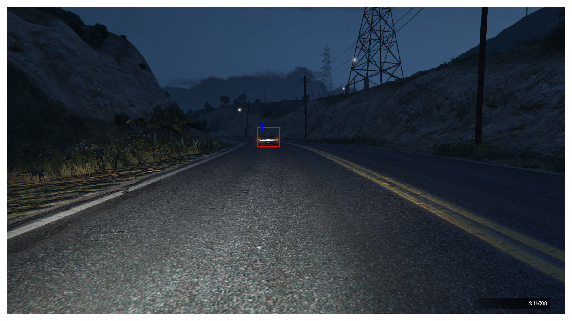

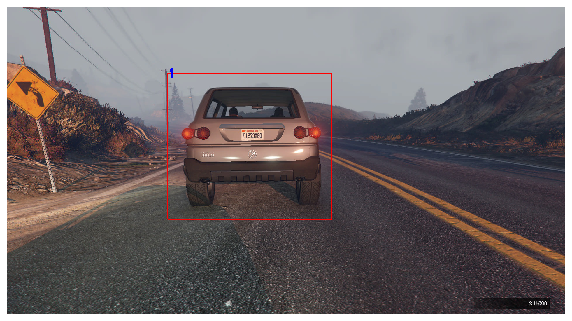

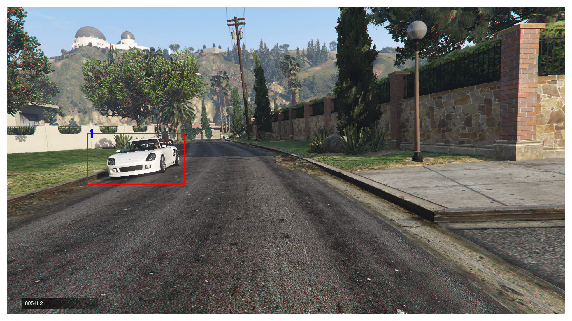

In [11]:
# visualize GT boxes
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  eecs598.vis.detection_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Region Proposal Network

## Overfit small data

In [12]:
np.random.choice(train_filenames, 10)

array(['06acf647-e2e9-4562-aa42-eed217e5bd84/0195',
       '06084349-6a34-4e47-8fab-e7a7ca3cbdd8/0006',
       '06acf647-e2e9-4562-aa42-eed217e5bd84/0197',
       '8e5bfc79-ce93-4752-89f8-ca76db553240/0035',
       '28016933-19b0-4398-a4bb-8362267395ba/0012',
       'af3ae5e6-27ef-4699-beb3-f2c72831a594/0015',
       'f075920b-5e7a-4c75-8ce8-3368d5f4254b/0070',
       '1fcce361-ab48-46a4-bbfb-f73bd4bf40e4/0026',
       '8fe618c9-8ea6-4f82-b634-cfebc8a47122/0117',
       '630f5200-f86e-490f-8764-1ecf1d398f5b/0155'], dtype=object)

In [13]:
RPNSolver = DetectionSolver
from two_stage_detector import RPN

# monitor the training loss
num_sample = 10
np.random.seed(0)
small_filenames = np.random.choice(train_filenames, num_sample, replace=False)
small_dataset = Dataset(small_filenames, 'train')
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

# for lr in [1e-3]:
#   print('lr: ', lr)
#   rpn = RPN()
#   RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

## Inference

In [14]:
RPNInference = DetectionInference

In [15]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
# ignore the dummy object class (in blue) as RPN does not output class!
RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)

NameError: name 'rpn' is not defined

# Faster RCNN

## Overfit small data

In [6]:
from two_stage_detector import TwoStageDetector

number of pos proposals:  10
(Iter 0 / 1)
(Epoch 0 / 200) loss: 11.1171 time per epoch: 1.7s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 1 / 200) loss: 10.1865 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 2 / 200) loss: 8.2962 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 3 / 200) loss: 7.7050 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 4 / 200) loss: 7.6790 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 5 / 200) loss: 6.5340 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 6 / 200) loss: 6.4424 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 7 / 200) loss: 6.4652 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 8 / 200) loss: 5.5255 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 9 / 200) loss: 6.0162 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 10 / 200) loss: 5.5926 time p

number of pos proposals:  10
(Iter 0 / 1)
(Epoch 89 / 200) loss: 2.4357 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 90 / 200) loss: 2.6742 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 91 / 200) loss: 2.2424 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 92 / 200) loss: 2.1027 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 93 / 200) loss: 2.5566 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 94 / 200) loss: 2.0825 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 95 / 200) loss: 2.3308 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 96 / 200) loss: 2.4752 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 97 / 200) loss: 2.2195 time per epoch: 0.6s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 98 / 200) loss: 2.5221 time per epoch: 0.6s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 99 / 200) loss: 2.536

number of pos proposals:  10
(Iter 0 / 1)
(Epoch 177 / 200) loss: 1.8630 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 178 / 200) loss: 1.8153 time per epoch: 0.6s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 179 / 200) loss: 1.5699 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 180 / 200) loss: 1.5363 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 181 / 200) loss: 1.5256 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 182 / 200) loss: 1.6723 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 183 / 200) loss: 1.8318 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 184 / 200) loss: 1.5596 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 185 / 200) loss: 1.7219 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 186 / 200) loss: 1.5216 time per epoch: 0.5s
number of pos proposals:  10
(Iter 0 / 1)
(Epoch 187 / 200) 

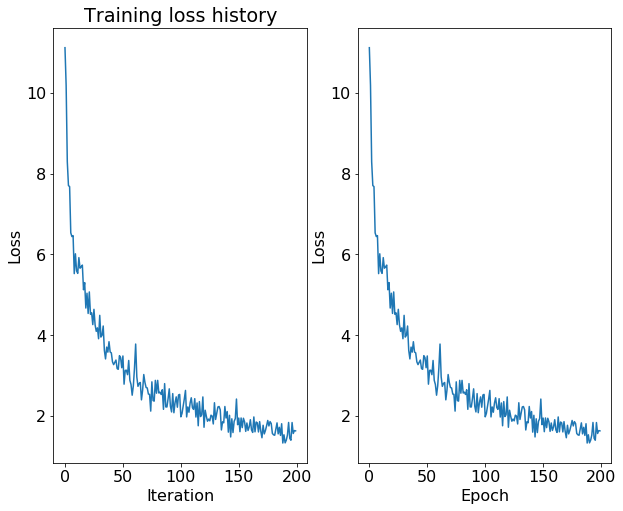

In [16]:
lr = 1e-3
detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

## Inference

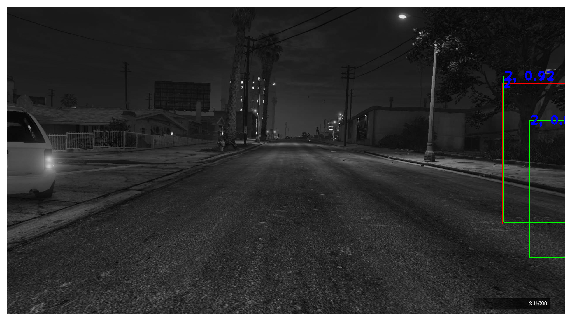

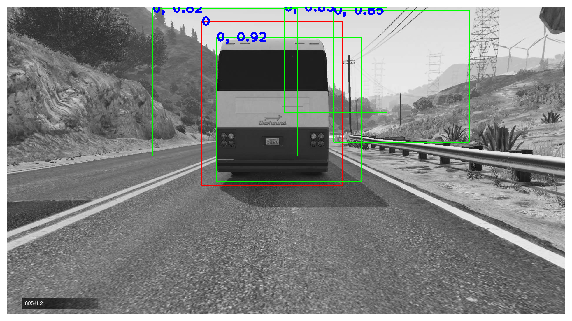

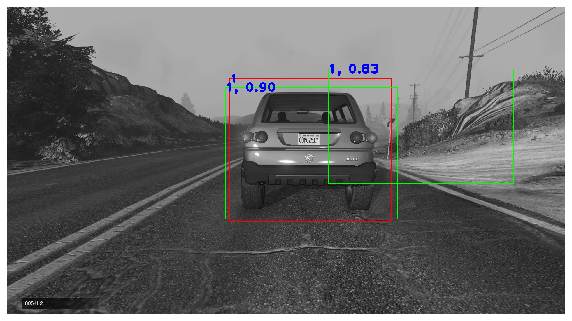

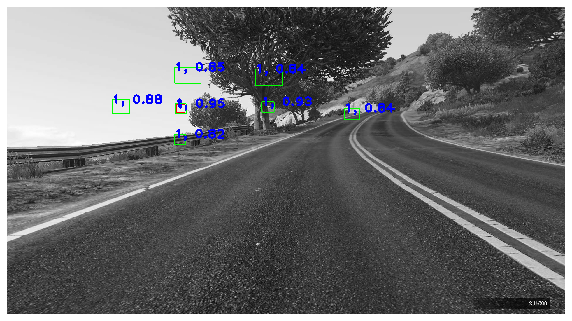

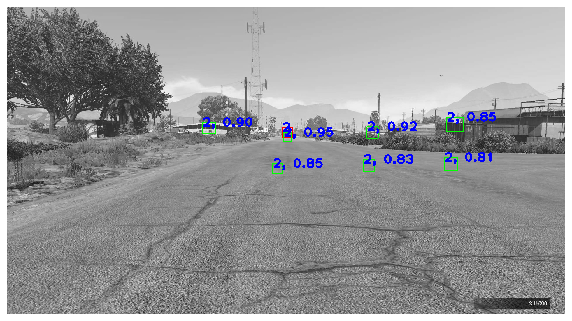

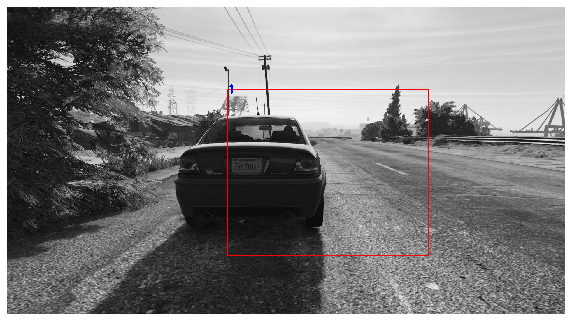

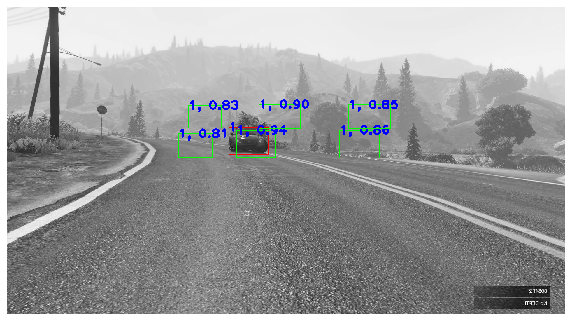

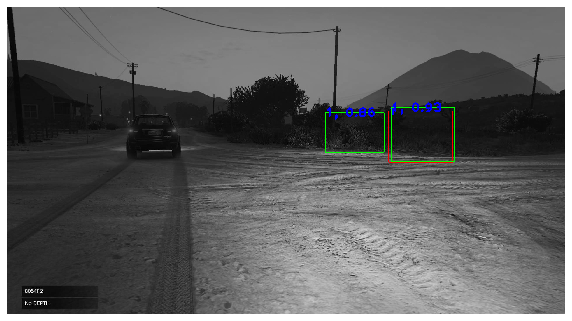

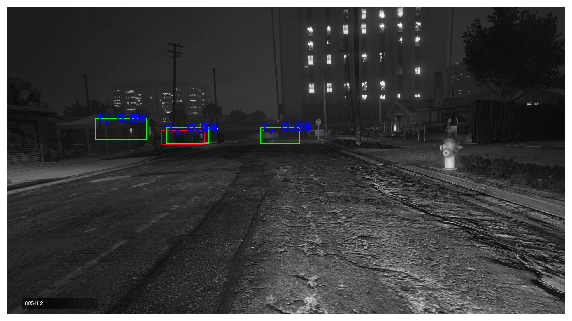

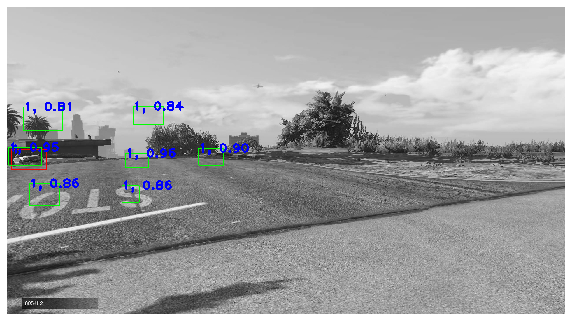

Total inference time: 2.7s


In [17]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.80, nms_thresh=0.3, dtype=torch.float32, device='cuda')

## Train a net

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, batch_size=5, shuffle=True)

num_epochs = 5000
lr = 5e-2
# frcnn_detector = TwoStageDetector(num_classes=3).to(dtype=torch.float32, device='cuda')
# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, frcnn_detector.parameters()),
#     lr)
DetectionSolver(frcnn_detector, train_loader, optimizer=None,
                learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

number of pos proposals:  6
(Iter 0 / 1515)
number of pos proposals:  5
(Iter 1 / 1515)
number of pos proposals:  5
(Iter 2 / 1515)
number of pos proposals:  5
(Iter 3 / 1515)
number of pos proposals:  5
(Iter 4 / 1515)
number of pos proposals:  5
(Iter 5 / 1515)
number of pos proposals:  5
(Iter 6 / 1515)
number of pos proposals:  6
(Iter 7 / 1515)
number of pos proposals:  6
(Iter 8 / 1515)
number of pos proposals:  5
(Iter 9 / 1515)
number of pos proposals:  6
(Iter 10 / 1515)
number of pos proposals:  5
(Iter 11 / 1515)
number of pos proposals:  5
(Iter 12 / 1515)
number of pos proposals:  5
(Iter 13 / 1515)
number of pos proposals:  6
(Iter 14 / 1515)
number of pos proposals:  5
(Iter 15 / 1515)
number of pos proposals:  5


In [7]:
# weights_path = os.path.join(GOOGLE_DRIVE_PATH, "frcnn_detector.pt")
# torch.save(frcnn_detector.state_dict(), weights_path) # uncomment to save your checkpoint

weights_path = os.path.join(GOOGLE_DRIVE_PATH, "frcnn_detector_0.67844.pt")
frcnn_detector = TwoStageDetector(num_classes=3).to(dtype=torch.float32, device='cuda')
frcnn_detector.load_state_dict(torch.load(weights_path)) # uncomment to load your previous checkpoint

<All keys matched successfully>

## Inference

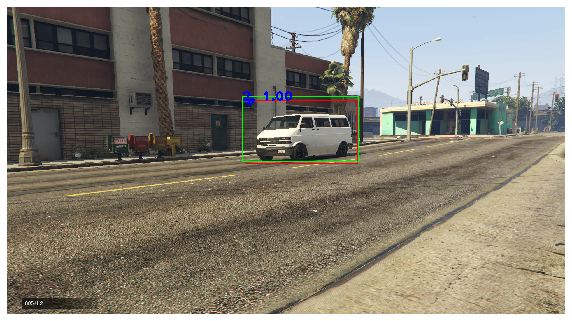

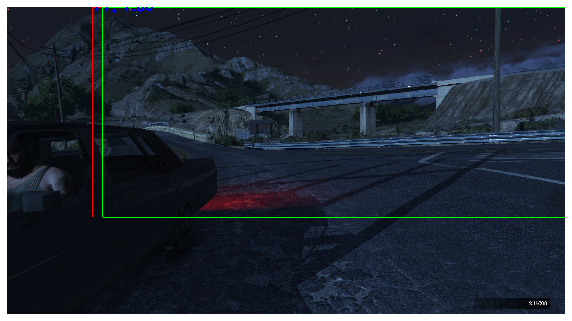

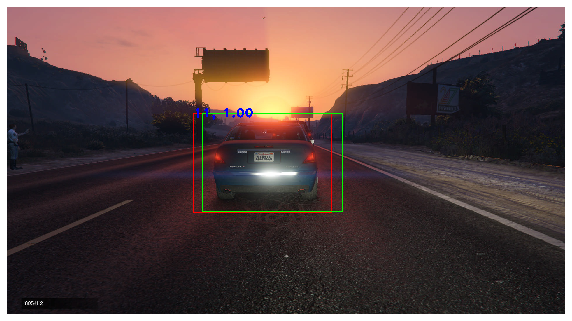

Total inference time: 0.9s


In [29]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
small_filenames = np.random.choice(train_filenames, 3, replace=False)
# small_filenames = np.array(['f9609d68-b897-4889-b67b-74bcf31b14f3/0035',
#        '09da3137-b836-479b-a4c9-5bdfa9b549e0/0005',
#        'e01aefe6-f367-4c00-b006-f9327a1ffc5f/0006'], dtype=object)
small_dataset = Dataset(small_filenames, 'train')
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader
DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class, device='cuda', dtype=torch.float32)

In [19]:
small_filenames

array(['f9609d68-b897-4889-b67b-74bcf31b14f3/0035',
       '09da3137-b836-479b-a4c9-5bdfa9b549e0/0005',
       'e01aefe6-f367-4c00-b006-f9327a1ffc5f/0006'], dtype=object)

In [20]:
filename = './trainval/' + small_filenames[-1] + '_bbox.bin'
np.fromfile(filename, dtype=np.float32)

array([ 0.03272727, -2.3011336 ,  2.086389  , -3.8515508 , -2.0231402 ,
       24.886587  ,  0.7236157 ,  2.2475336 ,  1.7898905 ,  9.        ,
        1.        ], dtype=float32)

## Testing data

In [8]:
# Load filenames for testing data
from glob import glob
files = glob('test/*/*_image.jpg')
files.sort()
test_filenames = []
for file in files:
    guid = file.split('\\')[-2]
    idx = file.split('\\')[-1].replace('_image.jpg', '')
    test_filenames.append(guid+'/'+idx)
n_test = len(test_filenames)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, filenames):
        self.filenames = filenames

    def __getitem__(self, idx):
        # load images and masks
        img_path = './test/' + self.filenames[idx] + '_image.jpg'
        img = Image.open(img_path).convert("RGB")
        img = img.resize((new_width, new_height))
#         ##########################################
#         img = img.convert(mode="L")
#         img = np.asarray(img)
#         img = img.reshape(*img.shape, 1)
#         img = np.concatenate([img, img, img], axis=-1).astype(np.uint8)
#         img = Image.fromarray(img, mode="RGB")
#         ##########################################
        box = [0, 0, 0, 0, 0]
        
        info = {'annotation': {}}
        info['annotation']['filename'] = self.filenames[idx]
        info['annotation']['object'] = [{'name': str(box[-1]),
                                         'bndbox': {'xmin': str(box[0]), 
                                                    'ymin': str(box[1]),
                                                    'xmax': str(box[2]), 
                                                    'ymax': str(box[3])}}]
        return img, info

    def __len__(self):
        return len(self.filenames)
    
test_dataset = TestDataset(test_filenames)

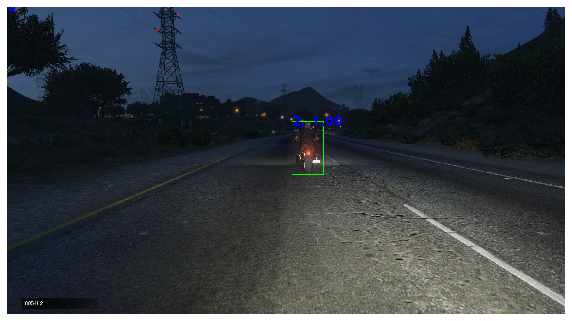

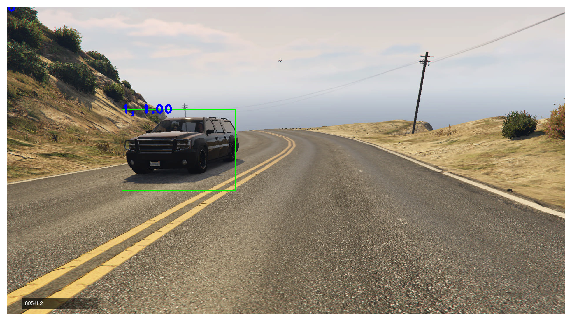

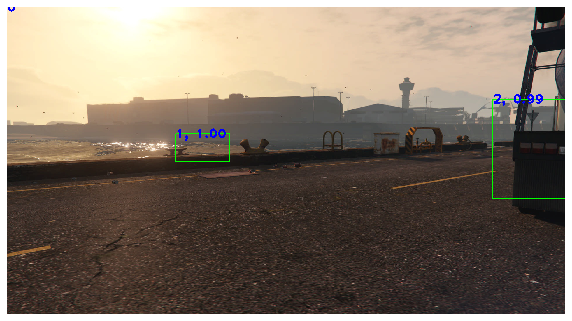

Total inference time: 1.0s


In [10]:
small_test_filenames = np.random.choice(test_filenames, 3, replace=False)
small_test_dataset = TestDataset(small_test_filenames)
small_test_loader = pascal_voc2007_loader(small_test_dataset, batch_size=1)
DetectionInference(frcnn_detector, small_test_loader, small_test_dataset, idx_to_class, device='cuda', dtype=torch.float32)

In [11]:
small_test_filenames

array(['f777190f-47f5-48af-aade-c73fc0fa8171/0072',
       'e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0064',
       '0729ab2d-7fb0-4799-975f-c38fd350bf9c/0077'], dtype='<U41')

In [18]:
test_loader = pascal_voc2007_loader(test_dataset, batch_size=1)
test_loader = iter(test_loader)
test_loader.next()

[tensor([[[[-1.2445, -1.2274, -0.8335,  ...,  1.7352,  1.7352,  1.7352],
           [-1.3815, -1.1418, -1.0219,  ...,  1.7352,  1.7352,  1.7352],
           [-1.3130, -1.3815, -1.2959,  ...,  1.7352,  1.7352,  1.7352],
           ...,
           [-0.3369, -0.4739, -0.4054,  ..., -0.7137, -0.7308, -0.8849],
           [-0.5082, -0.6109, -0.5082,  ..., -0.3712, -0.4397, -0.8164],
           [-0.5767, -0.4397, -0.3883,  ..., -0.5082, -0.3883, -0.7479]],
 
          [[-1.0378, -0.9853, -0.7927,  ...,  2.0259,  2.0259,  2.0259],
           [-1.0378, -0.9503, -1.0203,  ...,  2.0259,  2.0259,  2.0259],
           [-1.1078, -1.1779, -1.1253,  ...,  2.0259,  2.0259,  2.0259],
           ...,
           [-0.1975, -0.2675, -0.2150,  ..., -0.6176, -0.4776, -0.6702],
           [-0.3200, -0.4601, -0.3725,  ..., -0.2675, -0.3200, -0.6877],
           [-0.4251, -0.3025, -0.2150,  ..., -0.2325, -0.0399, -0.4251]],
 
          [[-0.7064, -0.6715, -0.5495,  ...,  2.3786,  2.3786,  2.3786],
           [-

In [13]:
device = torch.device("cuda:0")
labels_test = []
toFiles = ['guid/image,label\n']
test_loader = pascal_voc2007_loader(test_dataset, batch_size=1)
test_loader = iter(test_loader)
count = 0
with torch.no_grad():
    for i in trange(n_test):
        img, box, _, _, filename = test_loader.next()
        proposals, conf_scores, classes = frcnn_detector.inference(img.to(device), thresh=0.5)
        try:
            label = classes[0][0].item()
        except:
            label = 1
            count += 1
        labels_test.append(label)
        toFiles.append(filename[0]+','+str(label)+'\n')

100%|██████████████████████████████████████████████████████████████████████████████| 2631/2631 [02:12<00:00, 19.87it/s]


In [14]:
count

18

In [15]:
f = open('submission.txt', 'w')
f.writelines(toFiles)
f.close()